# solvekdv: a tutorial
Connor Duffin *The University of Western Australia*

This document covers the essentials behind the solvekdv package that I have written. The package's core functionality is
to use an implicit-explicit finite difference solver to solve the Korteweg-de Vries (K-dV) equation. It is linked to the oceanographic situations in which K-dV arises, but this functionality is only added in to compute the parameters. As such, for those who just want a basic K-dV solver, it can function in the fashion.

### The K-dV equation and its coefficients

To model internal waves in the ocean, the Korteweg-de Vries equation can be 
derived out of the Boussinesq approximation. This derivation is not the purpose
of the present document. The K-dV equation for the wave profile, $A$, is given by:

\begin{equation}
   A_t + c A_x + \alpha A A_x + \beta A_{xxx} - \frac{c}{Q} \frac{\mathrm d Q}{\mathrm d x} A = 0,
\end{equation}

where $c$, $\alpha$, $\beta$, $Q$ are all determined from the eigenvalue problem:

\begin{equation}
  \phi''(x) + \frac{N^2(z)}{c^2} = 0,
\end{equation}

where $\phi(0) = \phi(H) = 0$, $\max(\phi) = 1$. The coefficients are given by:

\begin{align}
  \alpha &= \frac{3c}{2} \frac{\int \mathrm (\phi'(z))^3d z}
  {\int (\phi'(z))^2 \mathrm d z}, \\
  \beta &= \frac{c}{2} \frac{\int \phi(z)^2 \mathrm d z}
  {\int (\phi'(z))^2 \mathrm d z}, \\
  Q &= \sqrt{\frac{c_0^3}{c^3} \frac{\int (\phi_0'(z))^2 \mathrm d z}
  {\int (\phi'(z))^2 \mathrm d z}}.
\end{align}

where $\phi_0$ is taken at some reference point (usually $x = 0$).

#### Solving the eigenvalue problem

Before we solve the K-dV equation, we need to first solve the eigenvalue 
equation. To do so we will use a finite difference scheme, accurate to
second order. Approximate the second derivative with a grid of points to 
give:

\begin{equation}
  \phi''(x)
  \approx \frac{\phi_{i + 1} - 2 \phi_{i} + \phi_{i - 1}}{(\Delta z)^2} = 
  \frac{-N_i^2}{c^2} \phi_i,
\end{equation}

where $\phi_i \approx \phi(i \Delta z)$, a grid point that serves to approximate
$\phi$ at the point $i \Delta z$. This problem forms an eigenvalue problem of 
the form:

\begin{equation}
  \mathbf A \boldsymbol{\phi} = \frac{1}{c^2} \mathbf n^\top \boldsymbol{\phi}
  \equiv
  \mathbf A \boldsymbol{\phi} = \lambda \mathbf n^\top \boldsymbol{\phi}.
\end{equation}

where $\mathbf A$ is a tridiagonal matrix  with $-1 / (\Delta x)^2$ on the two
off-diagonals and $2/(\Delta x)^2$ on the centre diagonal, $\boldsymbol \phi =
(\phi_1, \ldots, \phi_M)$, $\mathbf n = (N_1^2, \ldots, N_M^2)$ for our $M$
discretization points. This is a scaled matrix eigenvalue problem for the $M$
eigenvectors (which approximate the eigenfunctions), and the $M$ eigenvalues.

There are infinitely many eigenfunctions. We choose the eigenfunction according
to the lowest eigenvalue $\lambda_1$ such that
$\lambda_1 < \lambda_2 < \cdots$. If our eigenvalue is $\lambda$, then we have
$\lambda = 1 / c^2$ and then $c = \sqrt{1/\lambda}$.

The eigenfunction returned is not unique. It is known only to a normalising
constant. To combat this, we scale the eigenfunctions such that $\max \phi = 1$.

In practice, we use `scipy.linalg.eigh` to solve the system. It was initially
written to use the `scipy.sparse.eigs`, but this was actually *slower* than
just using `scipy.linalg.eigh`. As our matrices are not too big, in this case
($\sim 1000 \times 1000$), I decided to just use the faster one. To approximate
the derivatives we use the `numpy.gradient` function, and to approximate the
area under the curves, we use the `numpy.trapz` function.


#### IMEX routine to solve the K-dV

Now that we have these coefficients, we can run our K-dV model. Remember that K-dV equation is of the form:

\begin{equation}
  A_t + c A_x + \alpha A A_x + \beta A_{xxx}
  - \frac{c}{Q} \frac{\mathrm d Q}{\mathrm d x} A = 0.
\end{equation}

Following [Durran and Blossey](https://journals.ametsoc.org/doi/pdf/10.1175/MWR-D-11-00088.1)
we will represent the above PDE in terms of some linear operator $\mathcal L$, and
some nonlinear $f$. That, is, write:

\begin{equation}
  A_t = \mathcal L(A) + f(A).
\end{equation}

where $\mathcal L$ and $f$ are given by:

\begin{align}
  \mathcal L &= -c \partial_x - \beta \partial_{xxx} + \frac{c}{Q} \frac{\mathrm d Q}{\mathrm d x} \\
  f(A) &= -\alpha A \partial_{x} A.
\end{align}

We will use what Durran and Blossey call the AM2-AX2 scheme. Let $A^{n}$ represent
our finite approximation to $A$ at point $n$. Then the AM2-AX2 scheme is given 
by:

\begin{equation}
  \frac{A^{n + 1} - A^n}{\Delta t} 
  = \frac{7}{4} f(A^n) - f(A^{n - 1}) + \frac{1}{4} f(A^{n - 2})
  + \frac{3}{4} \mathcal L A^{n + 1} - \frac{1}{4} \mathcal L A^{n - 1}
\end{equation}

Notice that the nonlinear terms only go *backwards* in term and the linear terms
go forward, and backward, in time. This makes the nonlinear terms explicit, and
the linear terms are implicit. This gives:

\begin{align}
  A^{n + 1} - A^n
  = - &\frac{7 \Delta t}{4} \alpha A^n A^n_x
  + \Delta t \alpha A^{n - 1} A^{n - 1}_x
  - \frac{\Delta t}{4} \alpha A^{n - 2} A^{n - 2}_x \\
  &+ \frac{3 \Delta t}{4} \left(-c A^{n + 1}_x - \beta A^{n + 1}_{xxx}
    + \frac{c}{Q} \frac{\mathrm d Q}{\mathrm d x} A^{n + 1}\right)
  - \frac{\Delta t}{4} \left(-c A^{n - 1}_x - \beta A^{n - 1}_{xxx}
    + \frac{c}{Q} \frac{\mathrm d Q}{\mathrm d x} A^{n - 1}\right)
\end{align}

The only simplification I am going to do is put all of the terms involving the
$n + 1$ to the LHS, and all others to the RHS:

\begin{multline}
  A^{n + 1}
  + \frac{3 \Delta t}{4} \left(c A^{n + 1}_x + \beta A^{n + 1}_{xxx}
    - \frac{c}{Q} \frac{\mathrm d Q}{\mathrm d x} A^{n + 1}\right) \\
  = A^n - \frac{7 \Delta t}{4} \alpha A^n A^n_x
  + \Delta t \alpha A^{n - 1} A^{n - 1}_x
  - \frac{\Delta t}{4} \alpha A^{n - 2} A^{n - 2}_x
  + \frac{\Delta t}{4} \left(c A^{n - 1}_x + \beta A^{n - 1}_{xxx}
    - \frac{c}{Q} \frac{\mathrm d Q}{\mathrm d x} A^{n - 1}\right)
\end{multline}

Indeed, this looks messy. Replace all partial spatial derivatives with
their centered finite difference equivalents. The $\mathrm d Q / \mathrm d x$
term is known beforehand and is a constant.  In `solvekdv` we represent both
sides of this equation as matrices, to give an evolution equation of the form:

\begin{equation}
  \mathbf D \mathbf a^n = \mathbf b,
\end{equation}

where $\mathbf D$ is a matrix to represent the linear differential operators on
the RHS, $\mathbf a^n$ is the vector of approximating points of $A$, at time
point $n$, and $\mathbf b$ is a vector computed from the terms on the LHS
(which are all known).

### Using the package
This is a small example to show how to use `solvekdv` for non-varying
bathymetry (i.e. a flat ocean floor). First, load the package:

In [1]:
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from . import solvekdv

ImportError: cannot import name 'solvekdv' from '__main__' (unknown location)

 Set the depth to $300$ m, and the base density $\rho_0 = 1000 \, \mathrm{kg} \, \mathrm{m}^{-3}$. Then set up the vertical mode problem and so

In [40]:
vertical = vert.VerticalMode(dz=0.1, start_z=0, end_z=300, rho_0=1000)
vertical.compute_density("lamb-yan-1")

vertical.find_vertical_mode()

vertical.compute_r10()
vertical.compute_r01()

print(
    f"r10: {vertical.r10:.4f}\n"
    + f"r01: {vertical.r01:.4f}\n"
    + f"c:   {vertical.c:.4f}\n"
)

r10: -0.0166
r01: 2920.6500
c:   0.8427



Initialize the `kdv` class on our domain of interest ($(-150, 150)$ km, $24$ hours). Set the initial conditions to the same as those in Lamb & Yan (1996), and set the `kdv` equation parameters.

In [41]:
test = kdv.Kdv(
    dt=10, dx=50, start_x=-150000, end_x=150000, start_t=0, end_t=24 * 60**2
)

test.set_initial_condition(
    - 20 * (1/4) * (1 + np.tanh((test.x_grid + 20000) / 2000))
    * (1 - np.tanh(test.x_grid / 2000))
)

test.set_kdv_parameters(
    a=2 * vertical.r10 * vertical.c,
    b=vertical.r01,
    c=vertical.c
)

test.set_first_order_matrix()
test.set_third_order_matrix()
test.set_lhs_matrix()

We are now ready to solve the K-dV equation. Load up an array to store all of our iterations in and run the solver:

In [42]:
u = np.zeros([test.n_x, test.n_t])
for i in range(test.n_t):
    if (i % int(0.1 * test.n_t)) == 0:
        print(f"Simulation {100 * i / test.n_t:.1f} % complete.")
    u[:, i] = test.solve_step()
    

Simulation 0.0 % complete.
Simulation 10.0 % complete.
Simulation 20.0 % complete.
Simulation 30.0 % complete.
Simulation 40.0 % complete.
Simulation 50.0 % complete.
Simulation 60.0 % complete.
Simulation 70.0 % complete.
Simulation 80.0 % complete.
Simulation 90.0 % complete.


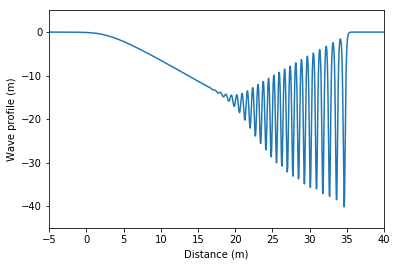

In [44]:
plt.plot(test.x_grid/1000, u[:, 3000])
plt.xlim((-5, 40))
plt.ylim((-45, 5))
plt.xlabel("Distance (m)")
plt.ylabel("Wave profile (m)")
plt.show()